In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
np.warnings.filterwarnings('ignore')

#is there GPU?
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Active Learning for Level Set Estimation of Black Box functions

Talk for [PyHEP2021](https://indico.cern.ch/event/1019958/) by [Irina Espejo](https://irinaespejo.github.io/)

Work by [Lukas Heinrich](http://www.lukasheinrich.com/), [Gilles Louppe](https://glouppe.github.io/), [Irina Espejo](https://irinaespejo.github.io/), [Patrick Rieck](https://inspirehep.net/authors/1078568) and [Kyle Cranmer](http://theoryandpractice.org/)

TABLE OF CONTENTS

## 1. What is this about and why do I care? <a class="anchor" id="1"></a>

- You care because this <bottom arrow> type of plot are the end step of a HEP experimental analysis. 
  They are also incredibly expensive to produce, evaluating each point has high latency of days or weeks.
  
  <img src="assets/ATLAS_contour.png" alt="Contour" title="A typical exclusion plot for a HEP analysis" width="400" height="400" class="center" />


- What can we do to scale this process up? This tutorial shows how to use `excursion`. It implements Active Learning with Gaussian Process Regression.
  
  <img src="assets/idea.png" alt="Idea" title="Idea behind Excursion" width="400" height="200" class="center" />

with [GPytorch](https://gpytorch.ai/) support

## 2. Setting of the problem <a class="anchor" id="2"></a>

<div class="alert alert-block alert-info">

We have a black box function $f_{BB}(\theta): \mathbb{R}^d \rightarrow \mathbb{R}$ and a threshold $t \in \mathbb{R}$. 

Each evaluation $f_{BB}(\theta_0)$ takes a long long time to process.

We want to find the level set $E_t(f_{BB}) = \{ \theta \in \mathbb{R}^d | f_{BB}(\theta) = t\}$

with as few queries to $f_{BB}$ as possible

</div>

Let's start with a 1D example for a better visualization. 

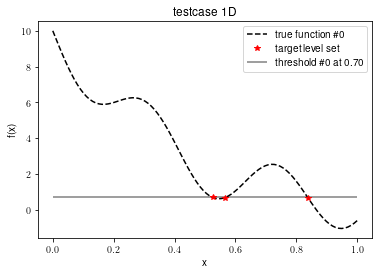

In [2]:
# import testcase 
import excursion
import excursion.testcases.fast_1D as testcase_1d

#plot testcase 
from excursion.plotting import plot_testcase_1d
plot_testcase_1d(testcase_1d, tol=0.05)

## 3. Specify the Gaussian Process prior

We use a Gaussian Process as a surrogate model for the Black Box function.
Gaussian Processes are non-parametric models where inductive bias is specified by the choice of mean and kernel. The observational model is specified by the likelihood.
GPyTorch has support for these [means](https://docs.gpytorch.ai/en/stable/means.html), [kernels](https://docs.gpytorch.ai/en/stable/kernels.html), [likelihoods](https://docs.gpytorch.ai/en/stable/models.html) and [inference models](https://docs.gpytorch.ai/en/stable/models.html)

We will use a constant mean, an RBF kernel $k(X, X') = C \exp{\left( -\frac{|| X-X' ||^2}{2l^2} \right)}$ and Exact Inference (no noise is added to the Black Box observation)

We anticipate two types of users:

    - Casual user for out-of-the-box usage and small tweaks
  
    - Advanced user who wants to have full control of all the moving parts _without_ messing with source code

### 3.1 Casual user

In [22]:
#load pre-existent algorithm options
import yaml
import json
file = open('excursion/testcases/algorithms/algorithm_specs.yaml', "r")
algorithm_opts = yaml.safe_load(file)

In [23]:
#initialize likelihood and GP with out-of-the-box options selected before
from excursion import init_gp
models, likelihood = init_gp(testcase_1d,             \
                             algorithm_opts,          \
                             device)

X_init  tensor([0.0303, 0.7374], dtype=torch.float64)
y_init  [tensor([8.7361, 2.4920], dtype=torch.float64)]


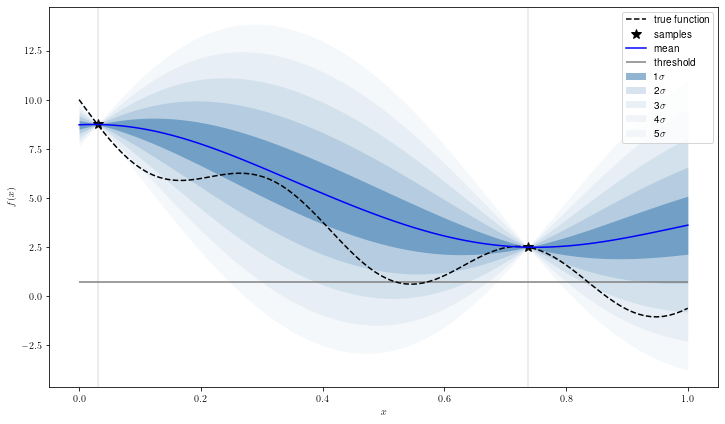

In [24]:
#plot gaussian process initialization
import excursion.plotting.onedim as plots
model = models[0]
plots.plot_GP(model, testcase_1d)

### 3.2 Advanced user

In [ ]:
import gpytorch

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

#initialize likelihood and GP
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# fit hyperparameters
model.train()
likelihood.train()
excursion.fit_hyperparams(model,likelihood)

#plot gaussian process initialization
import excursion.plotting.onedim as plots
plots.plot_GP(model, testcase_1d)

## 4. Initialize  Excursion Set Estimator <a class="anchor" id="4"></a>

The `ExcursionSetExtimator()`  object keeps internal track of the status of the Level Set Estimation.

For instance, stores the "next evaluation" suggestions, queries the black box and updates the Gaussian Process posterior.

In [ ]:
from excursion import ExcursionSetEstimator
estimator = ExcursionSetEstimator(testcase_1d,    \
                                  algorithm_opts, \
                                  models,         \
                                  likelihood,     \
                                  device)